# Import Library

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os
import time
from datetime import datetime
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Atur seed untuk reproduksibilitas
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# 1. Data Preprocessing

Memuat dan memproses dataset NusaX-Sentiment untuk analisis sentimen dalam Bahasa Indonesia.

Dataset sizes: Train=500, Valid=100, Test=400
Kelas dalam dataset: ['negative', 'neutral', 'positive']
Distribusi label train: [192 119 189]
Distribusi label valid: [38 24 38]
Distribusi label test: [153  96 151]


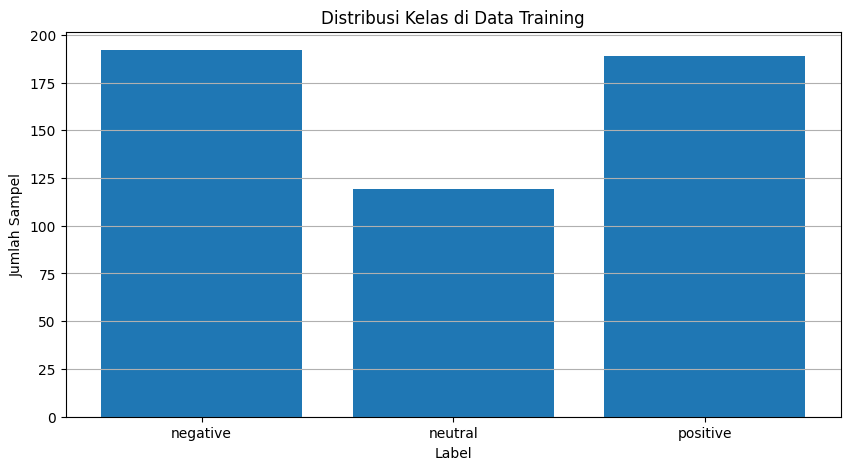

Vocabulary size: 2836

Contoh data:
Text: Nikmati cicilan 0% hingga 12 bulan untuk pemesanan tiket pesawat air asia dengan kartu kredit bni!... | Label: neutral
Text: Kue-kue yang disajikan bikin saya bernostalgia. Semuanya tipikal kue zaman dulu, baik dari penampila... | Label: positive
Text: Ibu pernah bekerja di grab indonesia... | Label: neutral


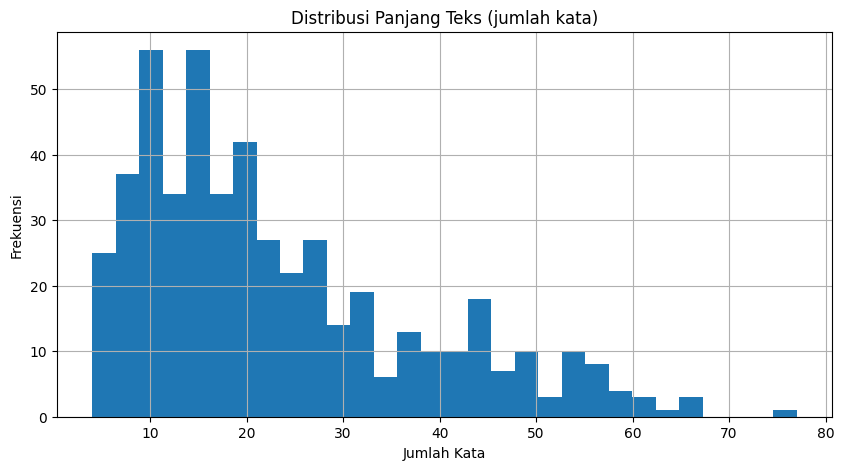

Panjang rata-rata (kata): 23.1
Panjang median (kata): 19.0
Panjang maksimum (kata): 77


In [16]:
from data_preprocessing import load_data, create_text_vectorizer, compute_f1_score

# Muat data
(train_texts, train_labels), (valid_texts, valid_labels), (test_texts, test_labels), label_mapping, num_classes = load_data()

# Tampilkan informasi data
print(f"Dataset sizes: Train={len(train_texts)}, Valid={len(valid_texts)}, Test={len(test_texts)}")
print(f"Kelas dalam dataset: {list(label_mapping.keys())}")
print(f"Distribusi label train: {np.bincount(train_labels)}")
print(f"Distribusi label valid: {np.bincount(valid_labels)}")
print(f"Distribusi label test: {np.bincount(test_labels)}")

# Visualisasi distribusi kelas
plt.figure(figsize=(10, 5))
class_counts = np.bincount(train_labels)
plt.bar(list(label_mapping.keys()), class_counts)
plt.title('Distribusi Kelas di Data Training')
plt.xlabel('Label')
plt.ylabel('Jumlah Sampel')
plt.grid(axis='y')
plt.show()

# Buat text vectorizer
vectorizer, vocab, vocab_size = create_text_vectorizer(train_texts)
print(f"Vocabulary size: {vocab_size}")

# Tampilkan beberapa contoh teks dan label
print("\nContoh data:")
for i in range(3):
    sentiment = list(label_mapping.keys())[train_labels[i]]
    print(f"Text: {train_texts[i][:100]}... | Label: {sentiment}")
    
# Visualisasikan panjang teks
text_lengths = [len(text.split()) for text in train_texts]
plt.figure(figsize=(10, 5))
plt.hist(text_lengths, bins=30)
plt.title('Distribusi Panjang Teks (jumlah kata)')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.grid(True)
plt.show()

print(f"Panjang rata-rata (kata): {np.mean(text_lengths):.1f}")
print(f"Panjang median (kata): {np.median(text_lengths):.1f}")
print(f"Panjang maksimum (kata): {np.max(text_lengths)}")

# 2 Model SimpleRNN Dasar

Di bagian ini kita akan membuat dan melatih model SimpleRNN dasar untuk klasifikasi sentimen.

In [17]:
from model import create_rnn_model
import config

# Cek parameter default dari config
print("Parameter model dari config.py:")
print(f"- Embedding dimension: {config.EMBEDDING_DIM}")
print(f"- RNN units: {config.RNN_UNITS}")
print(f"- Number of RNN layers: {config.NUM_RNN_LAYERS}")
print(f"- Bidirectional: {config.BIDIRECTIONAL}")
print(f"- Dropout rate: {config.DROPOUT_RATE}")
print(f"- Batch size: {config.BATCH_SIZE}")
print(f"- Max epochs: {config.EPOCHS}")

Parameter model dari config.py:
- Embedding dimension: 96
- RNN units: 48
- Number of RNN layers: 1
- Bidirectional: True
- Dropout rate: 0.3
- Batch size: 24
- Max epochs: 40



Pelatihan model baseline...

--- Training Model: baseline_model ---
Config: Layers=1, Units=48, Bidirectional=True, Dropout=0.3, L2=0.01
Ukuran dataset: Train=500, Valid=100, Test=400
Distribusi kelas di data train: [192 119 189]
Menggunakan bobot kelas: {0: 0.8680555555555556, 1: 1.4005602240896358, 2: 0.8818342151675485}
Ukuran vocabulary: 2836


Model: "Simple_RNN_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dropout               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_rnn_1             │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_rnn_1 (Dropout)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_layer (Dense)      │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Mulai pelatihan model...
Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2484 - loss: 5.3260
Epoch 1: val_loss improved from inf to 4.24739, saving model to checkpoints/baseline_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.2489 - loss: 5.3110 - val_accuracy: 0.3700 - val_loss: 4.2474 - learning_rate: 0.0010
Epoch 2/40
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4147 - loss: 4.0892
Epoch 2: val_loss improved from 4.24739 to 3.67587, saving model to checkpoints/baseline_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4142 - loss: 4.0667 - val_accuracy: 0.3000 - val_loss: 3.6759 - learning_rate: 0.0010
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4694 - loss: 3.5224
Epoch 3: val_loss improved from 3.67587 to 3.33166, saving model to checkpoints/baseline_model.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4684 - loss: 3.5192 - val_accuracy: 0.3600 - val_loss: 3.3317 - learning

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


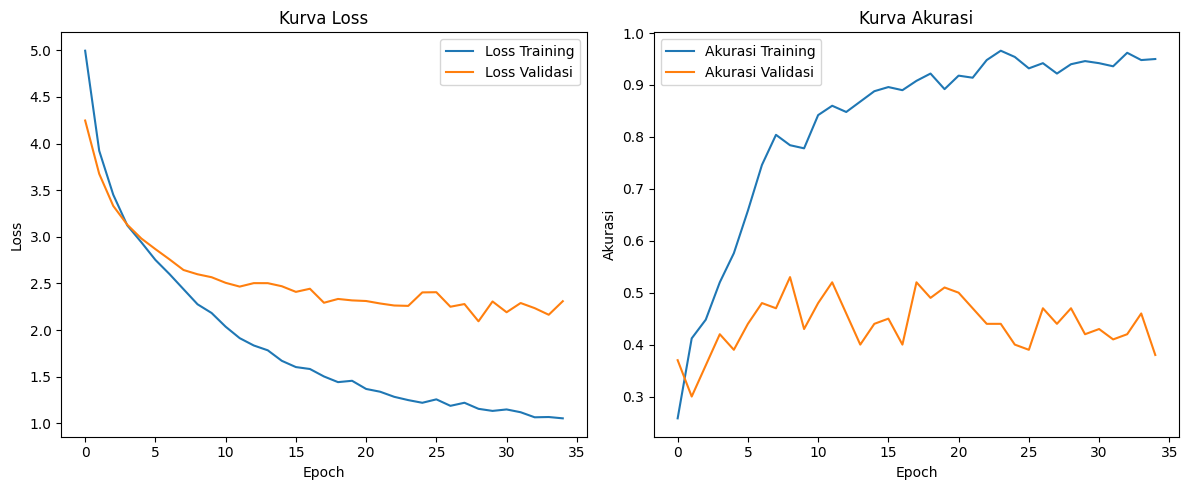


Metrik evaluasi model baseline:
Accuracy: 0.4900
F1 Score: 0.4443
Loss: 2.0305


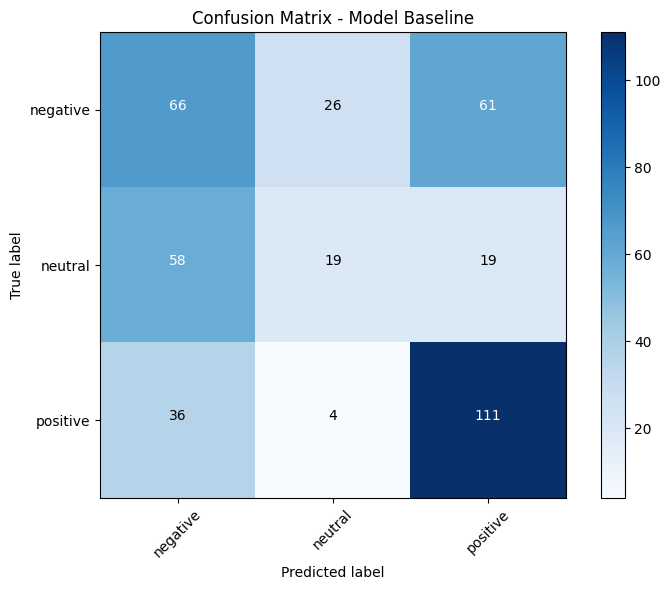

In [18]:
# Impor fungsi training dan evaluasi dari train.py
from train import train_and_evaluate_model, plot_training_history

# Buat folder untuk menyimpan hasil
os.makedirs("models", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)

# Latih model baseline
print("\nPelatihan model baseline...")
model_baseline, history_baseline, preds_baseline, labels_baseline, vectorizer_baseline, metrics_baseline = train_and_evaluate_model(
    model_name="baseline_model"
)

# Plot kurva training
plot_training_history(history_baseline, "baseline_model")

# Tampilkan metrik evaluasi
print("\nMetrik evaluasi model baseline:")
print(f"Accuracy: {metrics_baseline['test_accuracy']:.4f}")
print(f"F1 Score: {metrics_baseline['test_f1']:.4f}")
print(f"Loss: {metrics_baseline['test_loss']:.4f}")

# Visualisasi prediksi vs label sebenarnya
pred_classes = np.argmax(preds_baseline, axis=1)
cm = confusion_matrix(labels_baseline, pred_classes)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Model Baseline')
plt.colorbar()

class_names = list(label_mapping.keys())
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()

# Tambahkan teks nilai ke confusion matrix
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()

# 3. Eksperimen Variasi Parameter

Di bagian ini kita melakukan eksperimen untuk menguji pengaruh:
1. Jumlah layer RNN
2. Jumlah unit RNN
3. Arah RNN (unidirectional vs bidirectional)

In [19]:
RESULTS_DIR = "experiment_results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Definisikan variasi parameter yang akan diuji
RNN_LAYERS_VARIATIONS = [1, 2, 3]  # 3 variasi jumlah layer
RNN_UNITS_VARIATIONS = [24, 48, 96]  # 3 variasi jumlah unit per layer
BIDIRECTIONAL_VARIATIONS = [False, True]  # unidirectional vs bidirectional

## 3.1 Eksperimen Jumlah Layer
3 variasi jumlah layer RNN: 1, 2, dan 3 layer.

In [20]:
def run_layer_count_experiment():
    """Jalankan eksperimen untuk menguji pengaruh jumlah layer RNN"""
    print("\n" + "="*50)
    print("EKSPERIMEN: VARIASI JUMLAH LAYER RNN")
    print("="*50)
    
    results = []
    histories = {}
    
    # Uji untuk setiap jumlah layer
    for num_layers in RNN_LAYERS_VARIATIONS:
        model_name = f"rnn_layers_{num_layers}"
        print(f"\nTesting model dengan {num_layers} layer RNN")
        
        # Latih model dengan variasi ini
        start_time = time.time()
        _, history, preds, labels, _, metrics = train_and_evaluate_model(
            num_rnn_layers=num_layers,
            model_name=model_name
        )
        train_time = time.time() - start_time
        
        # Simpan hasilnya
        results.append({
            'num_layers': num_layers,
            'accuracy': metrics['test_accuracy'],
            'f1_score': metrics['test_f1'],
            'loss': metrics['test_loss'],
            'train_time': train_time
        })
        
        # Simpan history untuk plot
        histories[num_layers] = history
    
    # Konversi ke DataFrame untuk analisis lebih mudah
    results_df = pd.DataFrame(results)
    
    # Simpan hasil ke CSV (tanpa timestamp)
    csv_path = f"{RESULTS_DIR}/layer_count_results.csv"
    results_df.to_csv(csv_path, index=False)
    print(f"Hasil eksperimen jumlah layer disimpan di {csv_path}")
    
    return results_df, histories

# Jalankan eksperimen variasi jumlah layer RNN
layer_results_df, layer_histories = run_layer_count_experiment()


EKSPERIMEN: VARIASI JUMLAH LAYER RNN

Testing model dengan 1 layer RNN

--- Training Model: rnn_layers_1 ---
Config: Layers=1, Units=48, Bidirectional=True, Dropout=0.3, L2=0.01
Ukuran dataset: Train=500, Valid=100, Test=400
Distribusi kelas di data train: [192 119 189]
Menggunakan bobot kelas: {0: 0.8680555555555556, 1: 1.4005602240896358, 2: 0.8818342151675485}
Ukuran vocabulary: 2836


Model: "Simple_RNN_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dropout               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_rnn_1             │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_rnn_1 (Dropout)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_layer (Dense)      │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Mulai pelatihan model...
Epoch 1/40
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3044 - loss: 5.3184
Epoch 1: val_loss improved from inf to 4.29824, saving model to checkpoints/rnn_layers_1.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.3065 - loss: 5.2854 - val_accuracy: 0.3600 - val_loss: 4.2982 - learning_rate: 0.0010
Epoch 2/40
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3401 - loss: 4.2037
Epoch 2: val_loss improved from 4.29824 to 3.79967, saving model to checkpoints/rnn_layers_1.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3422 - loss: 4.1827 - val_accuracy: 0.3100 - val_loss: 3.7997 - learning_rate: 0.0010
Epoch 3/40
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4249 - loss: 3.7171
Epoch 3: val_loss improved from 3.79967 to 3.48153, saving model to checkpoints/rnn_layers_1.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4226 - loss: 3.7063 - val_accuracy: 0.3200 - val_loss: 3.4815 - learning_rate:

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


Model: "Simple_RNN_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dropout               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_rnn_1             │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_rnn_1 (Dropout)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_rnn_2             │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_rnn_2 (Dropout)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_layer (Dense)      │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Mulai pelatihan model...
Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3561 - loss: 7.5116
Epoch 1: val_loss improved from inf to 6.39144, saving model to checkpoints/rnn_layers_2.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.3537 - loss: 7.4976 - val_accuracy: 0.3500 - val_loss: 6.3914 - learning_rate: 0.0010
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3494 - loss: 6.2474
Epoch 2: val_loss improved from 6.39144 to 5.67397, saving model to checkpoints/rnn_layers_2.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3495 - loss: 6.2404 - val_accuracy: 0.4500 - val_loss: 5.6740 - learning_rate: 0.0010
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4269 - loss: 5.5403
Epoch 3: val_loss improved from 5.67397 to 5.21782, saving model to checkpoints/rnn_layers_2.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4272 - loss: 5.5369 - val_accuracy: 0.4200 - val_loss: 5.2178 - learning_rate

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


Model: "Simple_RNN_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dropout               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_rnn_1             │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_rnn_1 (Dropout)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_rnn_2             │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_rnn_2 (Dropout)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_rnn_3             │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_rnn_3 (Dropout)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_layer (Dense)      │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Mulai pelatihan model...
Epoch 1/40
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3107 - loss: 9.9734 
Epoch 1: val_loss improved from inf to 8.79003, saving model to checkpoints/rnn_layers_3.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 117ms/step - accuracy: 0.3135 - loss: 9.9360 - val_accuracy: 0.3500 - val_loss: 8.7900 - learning_rate: 0.0010
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3987 - loss: 8.7042
Epoch 2: val_loss improved from 8.79003 to 8.28806, saving model to checkpoints/rnn_layers_3.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.3979 - loss: 8.6986 - val_accuracy: 0.3800 - val_loss: 8.2881 - learning_rate: 0.0010
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4400 - loss: 8.0899
Epoch 3: val_loss improved from 8.28806 to 7.61917, saving model to checkpoints/rnn_layers_3.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.4393 - loss: 8.0852 - val_accuracy: 0.4600 - val_loss: 7.6192 - learning_ra

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)



Hasil Eksperimen Jumlah Layer:


,num_layers,accuracy,f1_score,loss,train_time
0,1,0.5950,0.559938,1.621912,29.756603
1,2,0.4175,0.389573,2.483728,40.634016
2,3,0.5550,0.514916,2.094238,56.088178


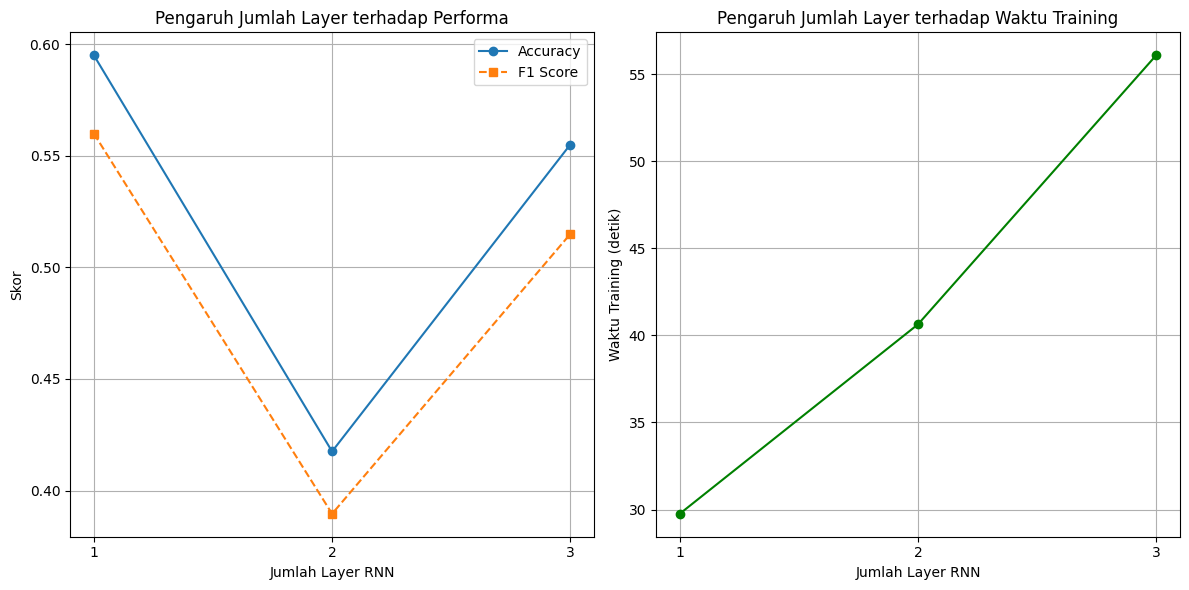

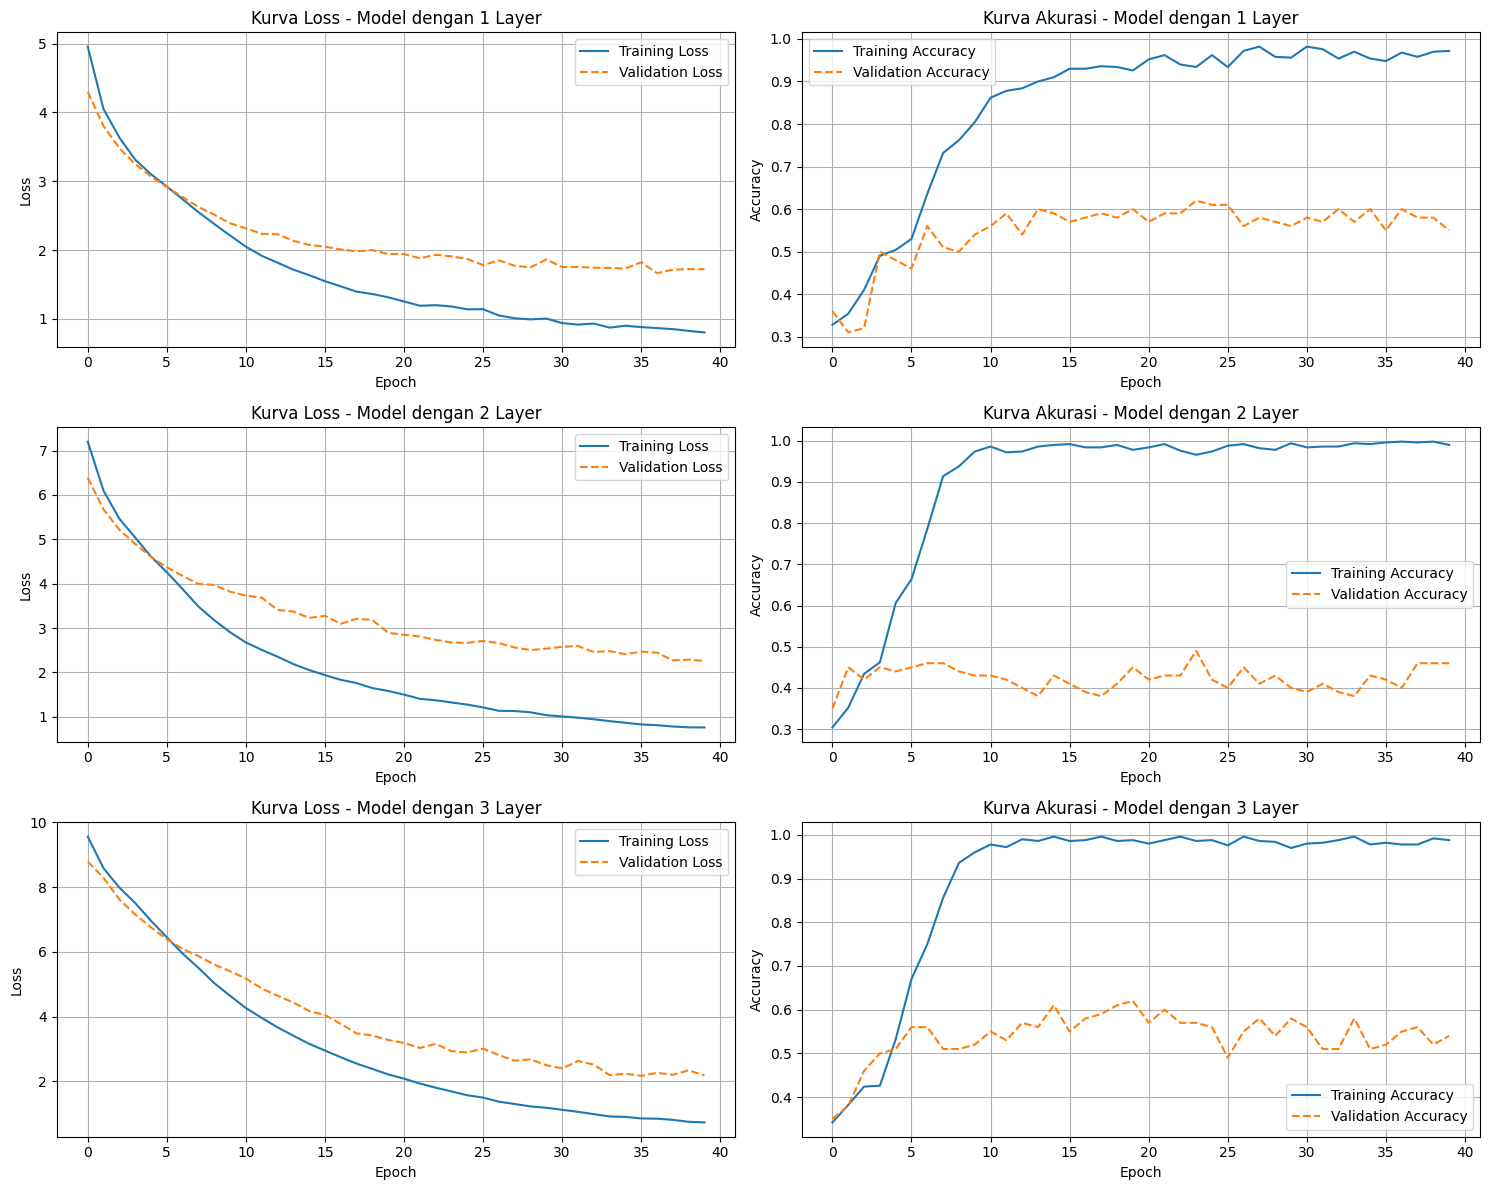

In [21]:
# Tampilkan hasil dalam tabel
print("\nHasil Eksperimen Jumlah Layer:")
display(layer_results_df)

# Visualisasikan pengaruh jumlah layer terhadap performa
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(layer_results_df['num_layers'], layer_results_df['accuracy'], 'o-', label='Accuracy')
plt.plot(layer_results_df['num_layers'], layer_results_df['f1_score'], 's--', label='F1 Score')
plt.xlabel('Jumlah Layer RNN')
plt.ylabel('Skor')
plt.title('Pengaruh Jumlah Layer terhadap Performa')
plt.xticks(layer_results_df['num_layers'])
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(layer_results_df['num_layers'], layer_results_df['train_time'], 'o-', color='green')
plt.xlabel('Jumlah Layer RNN')
plt.ylabel('Waktu Training (detik)')
plt.title('Pengaruh Jumlah Layer terhadap Waktu Training')
plt.xticks(layer_results_df['num_layers'])
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot kurva learning untuk setiap variasi jumlah layer (satu model per plot)
plt.figure(figsize=(15, 4 * len(RNN_LAYERS_VARIATIONS)))

for i, layers in enumerate(RNN_LAYERS_VARIATIONS):
    # Plot Loss
    plt.subplot(len(RNN_LAYERS_VARIATIONS), 2, 2*i + 1)
    plt.plot(layer_histories[layers].history['loss'], label='Training Loss')
    plt.plot(layer_histories[layers].history['val_loss'], '--', label='Validation Loss')
    plt.title(f'Kurva Loss - Model dengan {layers} Layer')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(len(RNN_LAYERS_VARIATIONS), 2, 2*i + 2)
    plt.plot(layer_histories[layers].history['accuracy'], label='Training Accuracy')
    plt.plot(layer_histories[layers].history['val_accuracy'], '--', label='Validation Accuracy')
    plt.title(f'Kurva Akurasi - Model dengan {layers} Layer')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


## 3.2 Eksperimen Jumlah Unit RNN
3 variasi jumlah unit per layer: 24, 48, dan 96 unit

In [22]:
def run_unit_count_experiment():
    """Jalankan eksperimen untuk menguji pengaruh jumlah unit RNN"""
    print("\n" + "="*50)
    print("EKSPERIMEN: VARIASI JUMLAH UNIT RNN")
    print("="*50)
    
    results = []
    histories = {}
    
    # Uji untuk setiap jumlah unit
    for num_units in RNN_UNITS_VARIATIONS:
        model_name = f"rnn_units_{num_units}"
        print(f"\nTesting model dengan {num_units} unit RNN")
        
        # Latih model dengan variasi ini
        start_time = time.time()
        _, history, preds, labels, _, metrics = train_and_evaluate_model(
            rnn_units=num_units,
            model_name=model_name
        )
        train_time = time.time() - start_time
        
        # Simpan hasilnya
        results.append({
            'num_units': num_units,
            'accuracy': metrics['test_accuracy'],
            'f1_score': metrics['test_f1'],
            'loss': metrics['test_loss'],
            'train_time': train_time
        })
        
        # Simpan history untuk plot
        histories[num_units] = history
    
    # Konversi ke DataFrame
    results_df = pd.DataFrame(results)
    
    # Simpan hasil ke CSV
    csv_path = f"{RESULTS_DIR}/unit_count_results.csv"
    results_df.to_csv(csv_path, index=False)
    print(f"Hasil eksperimen jumlah unit disimpan di {csv_path}")
    
    return results_df, histories

# Jalankan eksperimen variasi jumlah unit RNN
unit_results_df, unit_histories = run_unit_count_experiment()


EKSPERIMEN: VARIASI JUMLAH UNIT RNN

Testing model dengan 24 unit RNN

--- Training Model: rnn_units_24 ---
Config: Layers=1, Units=24, Bidirectional=True, Dropout=0.3, L2=0.01
Ukuran dataset: Train=500, Valid=100, Test=400
Distribusi kelas di data train: [192 119 189]
Menggunakan bobot kelas: {0: 0.8680555555555556, 1: 1.4005602240896358, 2: 0.8818342151675485}
Ukuran vocabulary: 2836


Model: "Simple_RNN_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dropout               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_rnn_1             │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_rnn_1 (Dropout)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_layer (Dense)      │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Mulai pelatihan model...
Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3346 - loss: 4.3007
Epoch 1: val_loss improved from inf to 3.31145, saving model to checkpoints/rnn_units_24.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.3357 - loss: 4.2843 - val_accuracy: 0.4100 - val_loss: 3.3115 - learning_rate: 0.0010
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3851 - loss: 3.2143
Epoch 2: val_loss improved from 3.31145 to 2.87638, saving model to checkpoints/rnn_units_24.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3857 - loss: 3.2096 - val_accuracy: 0.4900 - val_loss: 2.8764 - learning_rate: 0.0010
Epoch 3/40
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4468 - loss: 2.8113
Epoch 3: val_loss improved from 2.87638 to 2.60822, saving model to checkpoints/rnn_units_24.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4553 - loss: 2.7991 - val_accuracy: 0.4900 - val_loss: 2.6082 - learning_rate

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


Model: "Simple_RNN_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dropout               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_rnn_1             │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_rnn_1 (Dropout)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_layer (Dense)      │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Mulai pelatihan model...
Epoch 1/40
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3531 - loss: 5.2459
Epoch 1: val_loss improved from inf to 4.14147, saving model to checkpoints/rnn_units_48.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.3528 - loss: 5.1924 - val_accuracy: 0.4500 - val_loss: 4.1415 - learning_rate: 0.0010
Epoch 2/40
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3919 - loss: 3.9999
Epoch 2: val_loss improved from 4.14147 to 3.55207, saving model to checkpoints/rnn_units_48.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3915 - loss: 3.9769 - val_accuracy: 0.4000 - val_loss: 3.5521 - learning_rate: 0.0010
Epoch 3/40
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4603 - loss: 3.3988
Epoch 3: val_loss improved from 3.55207 to 3.25109, saving model to checkpoints/rnn_units_48.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4586 - loss: 3.3947 - val_accuracy: 0.4100 - val_loss: 3.2511 - learning_rate:

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


Model: "Simple_RNN_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dropout               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_rnn_1             │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_rnn_1 (Dropout)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_layer (Dense)      │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Mulai pelatihan model...
Epoch 1/40
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2915 - loss: 6.8268
Epoch 1: val_loss improved from inf to 5.49349, saving model to checkpoints/rnn_units_96.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.2930 - loss: 6.7855 - val_accuracy: 0.3700 - val_loss: 5.4935 - learning_rate: 0.0010
Epoch 2/40
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3444 - loss: 5.3147
Epoch 2: val_loss improved from 5.49349 to 4.62477, saving model to checkpoints/rnn_units_96.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3484 - loss: 5.2935 - val_accuracy: 0.4200 - val_loss: 4.6248 - learning_rate: 0.0010
Epoch 3/40
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4090 - loss: 4.5308
Epoch 3: val_loss improved from 4.62477 to 4.19871, saving model to checkpoints/rnn_units_96.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4104 - loss: 4.5183 - val_accuracy: 0.3800 - val_loss: 4.1987 - learning_rate:

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)



Hasil Eksperimen Jumlah Unit RNN:


,num_units,accuracy,f1_score,loss,train_time
0,24,0.675,0.664583,1.426831,31.007717
1,48,0.585,0.562694,1.735264,29.974332
2,96,0.610,0.590169,1.691731,31.047235


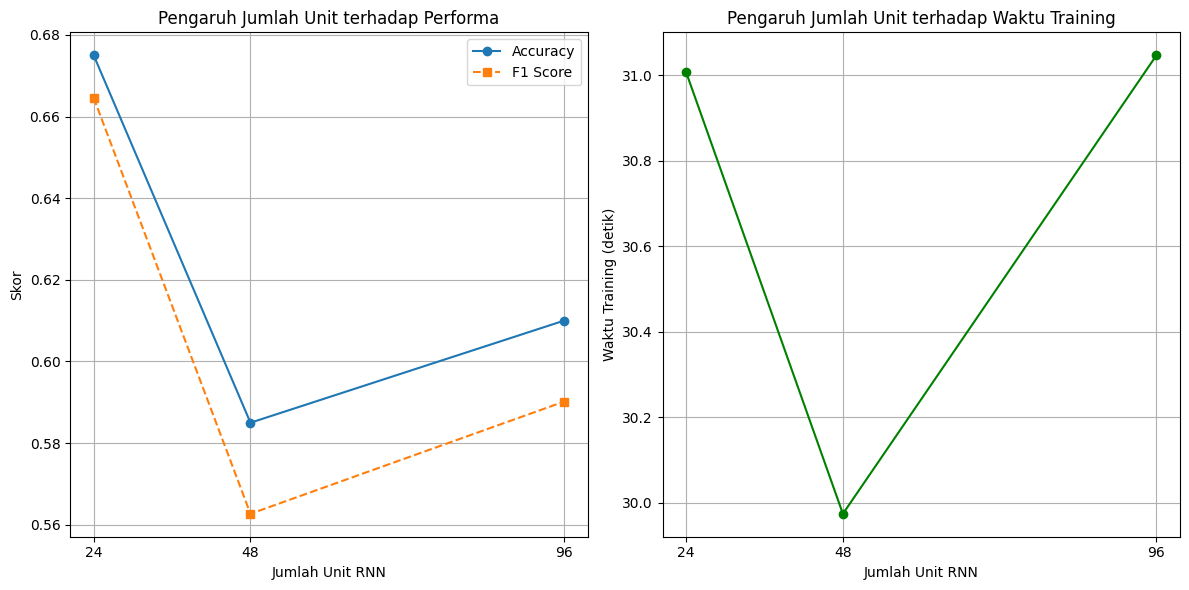

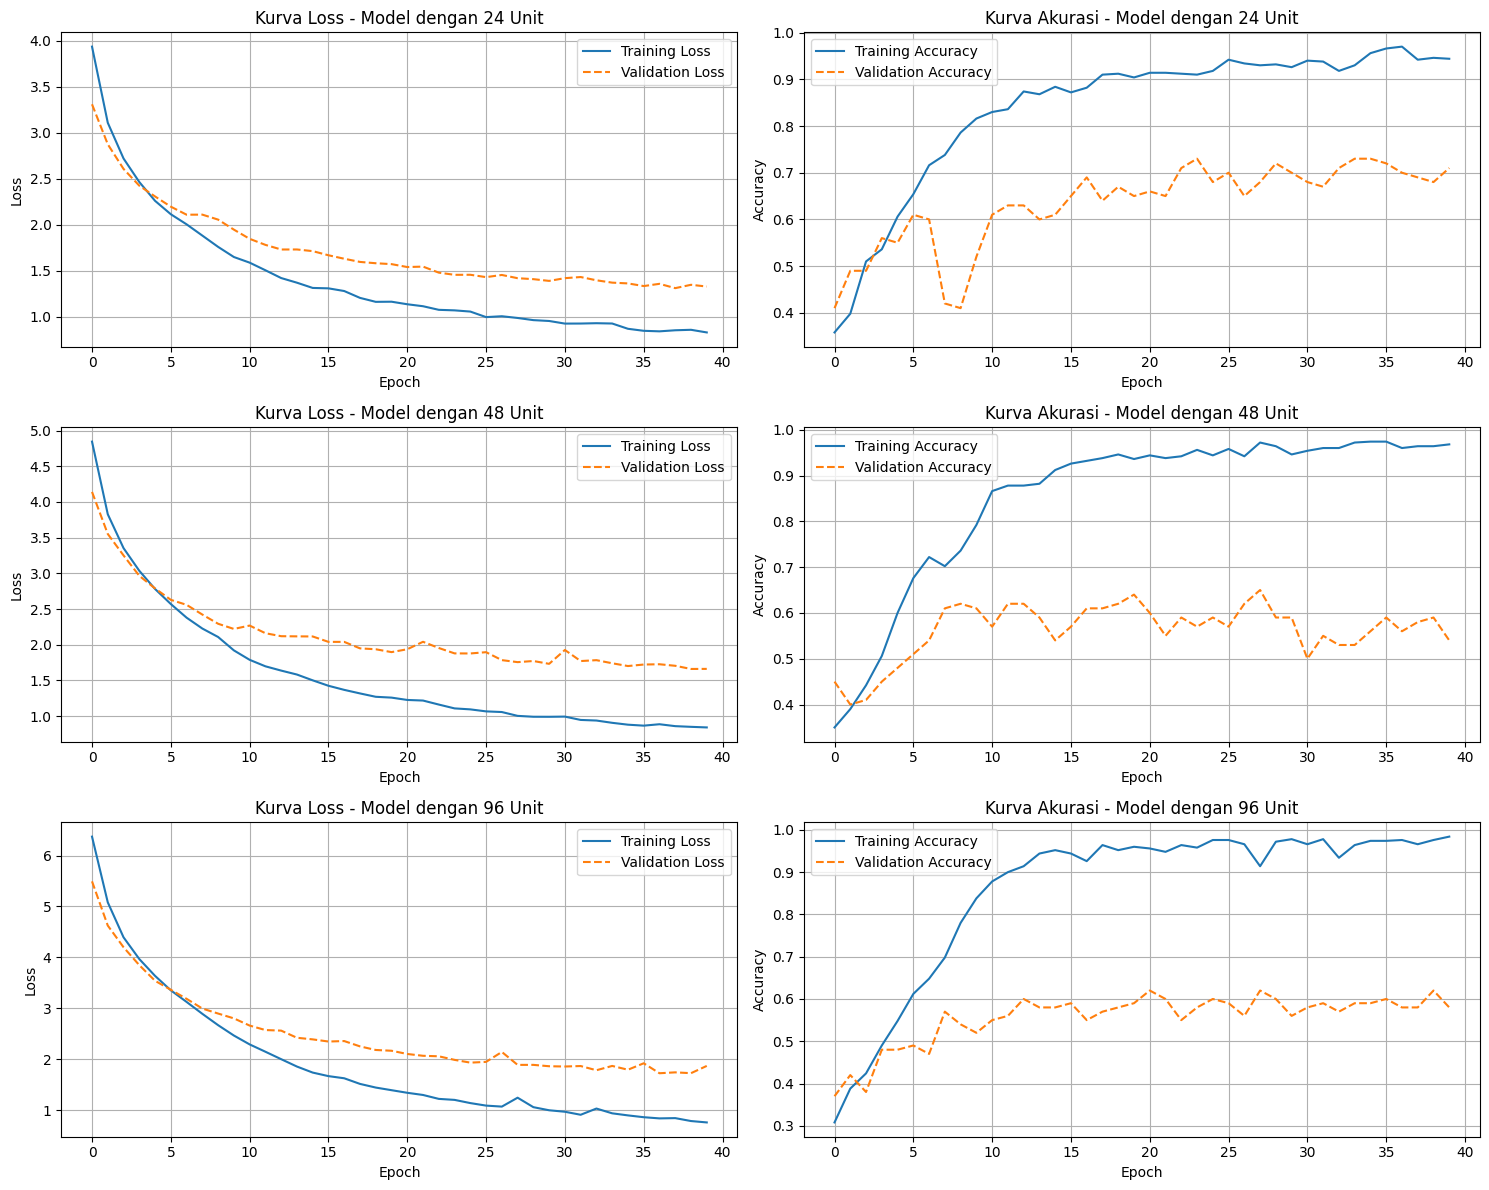

In [23]:
# Tampilkan hasil dalam tabel
print("\nHasil Eksperimen Jumlah Unit RNN:")
display(unit_results_df)

# Visualisasikan pengaruh jumlah unit
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(unit_results_df['num_units'], unit_results_df['accuracy'], 'o-', label='Accuracy')
plt.plot(unit_results_df['num_units'], unit_results_df['f1_score'], 's--', label='F1 Score')
plt.xlabel('Jumlah Unit RNN')
plt.ylabel('Skor')
plt.title('Pengaruh Jumlah Unit terhadap Performa')
plt.xticks(unit_results_df['num_units'])
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(unit_results_df['num_units'], unit_results_df['train_time'], 'o-', color='green')
plt.xlabel('Jumlah Unit RNN')
plt.ylabel('Waktu Training (detik)')
plt.title('Pengaruh Jumlah Unit terhadap Waktu Training')
plt.xticks(unit_results_df['num_units'])
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot kurva learning untuk setiap variasi jumlah unit
plt.figure(figsize=(15, 4 * len(RNN_UNITS_VARIATIONS)))

for i, units in enumerate(RNN_UNITS_VARIATIONS):
    # Plot Loss
    plt.subplot(len(RNN_UNITS_VARIATIONS), 2, 2*i + 1)
    plt.plot(unit_histories[units].history['loss'], label='Training Loss')
    plt.plot(unit_histories[units].history['val_loss'], '--', label='Validation Loss')
    plt.title(f'Kurva Loss - Model dengan {units} Unit')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(len(RNN_UNITS_VARIATIONS), 2, 2*i + 2)
    plt.plot(unit_histories[units].history['accuracy'], label='Training Accuracy')
    plt.plot(unit_histories[units].history['val_accuracy'], '--', label='Validation Accuracy')
    plt.title(f'Kurva Akurasi - Model dengan {units} Unit')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


# 3.3 Eksperimen RNN Bidirectional vs Unidirectional
2 variasi arah RNN: unidirectional dan bidirectional

In [24]:
def run_bidirectional_experiment():
    """Jalankan eksperimen untuk membandingkan RNN satu arah vs dua arah"""
    print("\n" + "="*50)
    print("EKSPERIMEN: VARIASI RNN BERDASARKAN ARAH")
    print("="*50)
    
    results = []
    histories = {}
    
    # Uji untuk setiap setting bidirectional
    for is_bidirectional in BIDIRECTIONAL_VARIATIONS:
        direction_name = "bidirectional" if is_bidirectional else "unidirectional"
        model_name = f"rnn_{direction_name}"
        print(f"\nTesting model dengan RNN {direction_name}")
        
        # Latih model dengan variasi ini
        start_time = time.time()
        _, history, preds, labels, _, metrics = train_and_evaluate_model(
            bidirectional=is_bidirectional,
            model_name=model_name
        )
        train_time = time.time() - start_time
        
        # Simpan hasilnya
        results.append({
            'is_bidirectional': is_bidirectional,
            'direction': direction_name,
            'accuracy': metrics['test_accuracy'],
            'f1_score': metrics['test_f1'],
            'loss': metrics['test_loss'],
            'train_time': train_time
        })
        
        # Simpan history untuk plot
        histories[direction_name] = history
    
    # Konversi ke DataFrame
    results_df = pd.DataFrame(results)
    
    # Simpan hasil ke CSV
    csv_path = f"{RESULTS_DIR}/bidirectional_results.csv"
    results_df.to_csv(csv_path, index=False)
    print(f"Hasil eksperimen arah RNN disimpan di {csv_path}")
    
    return results_df, histories

# Jalankan eksperimen variasi arah RNN
bidirectional_results_df, bidirectional_histories = run_bidirectional_experiment()


EKSPERIMEN: VARIASI RNN BERDASARKAN ARAH

Testing model dengan RNN unidirectional

--- Training Model: rnn_unidirectional ---
Config: Layers=1, Units=48, Bidirectional=False, Dropout=0.3, L2=0.01
Ukuran dataset: Train=500, Valid=100, Test=400
Distribusi kelas di data train: [192 119 189]
Menggunakan bobot kelas: {0: 0.8680555555555556, 1: 1.4005602240896358, 2: 0.8818342151675485}
Ukuran vocabulary: 2836


Model: "Simple_RNN_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dropout               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simplernn_layer_1 (SimpleRNN)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_rnn_1 (Dropout)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_layer (Dense)      │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Mulai pelatihan model...
Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3533 - loss: 4.1223
Epoch 1: val_loss improved from inf to 3.06624, saving model to checkpoints/rnn_unidirectional.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.3535 - loss: 4.1049 - val_accuracy: 0.2500 - val_loss: 3.0662 - learning_rate: 0.0010
Epoch 2/40
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3395 - loss: 2.9404
Epoch 2: val_loss improved from 3.06624 to 2.57823, saving model to checkpoints/rnn_unidirectional.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3410 - loss: 2.9287 - val_accuracy: 0.2500 - val_loss: 2.5782 - learning_rate: 0.0010
Epoch 3/40
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3334 - loss: 2.5482
Epoch 3: val_loss improved from 2.57823 to 2.33605, saving model to checkpoints/rnn_unidirectional.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3313 - loss: 2.5376 - val_accuracy: 0.3600 - val_loss: 2.336

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


Model: "Simple_RNN_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dropout               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_rnn_1             │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_rnn_1 (Dropout)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_layer (Dense)      │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Mulai pelatihan model...
Epoch 1/40
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3929 - loss: 5.2348
Epoch 1: val_loss improved from inf to 4.16671, saving model to checkpoints/rnn_bidirectional.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.3900 - loss: 5.1988 - val_accuracy: 0.4300 - val_loss: 4.1667 - learning_rate: 0.0010
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4029 - loss: 4.0162
Epoch 2: val_loss improved from 4.16671 to 3.58264, saving model to checkpoints/rnn_bidirectional.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4042 - loss: 4.0093 - val_accuracy: 0.5500 - val_loss: 3.5826 - learning_rate: 0.0010
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5173 - loss: 3.4816
Epoch 3: val_loss improved from 3.58264 to 3.24094, saving model to checkpoints/rnn_bidirectional.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5182 - loss: 3.4781 - val_accuracy: 0.4900 - val_loss: 3.2409 -

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)



Hasil Eksperimen Arah RNN:


,is_bidirectional,direction,accuracy,f1_score,loss,train_time
0,False,unidirectional,0.3775,0.182698,1.170757,19.357722
1,True,bidirectional,0.6000,0.579119,1.677463,30.322701


<Figure size 1000x600 with 0 Axes>

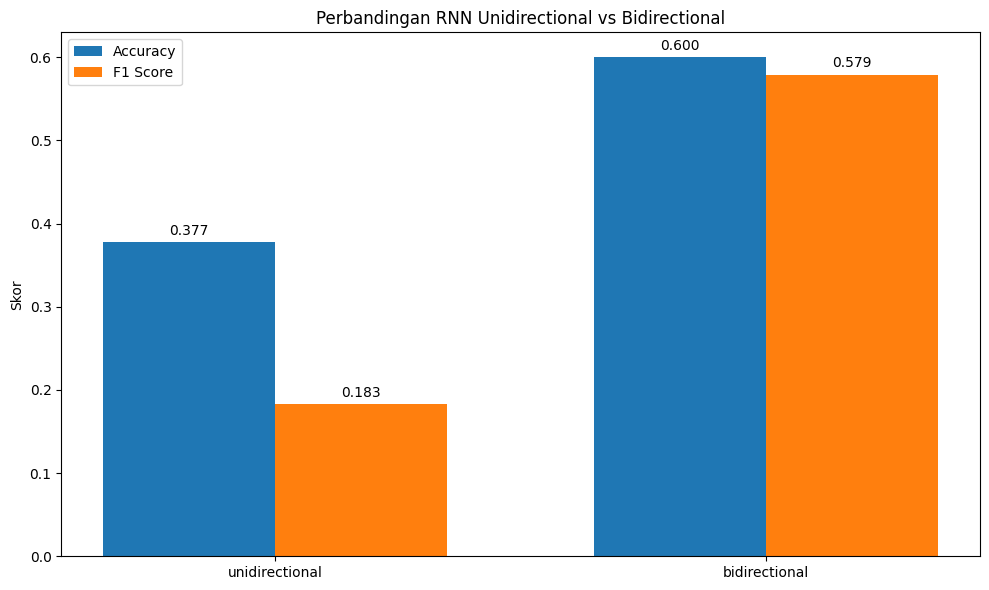

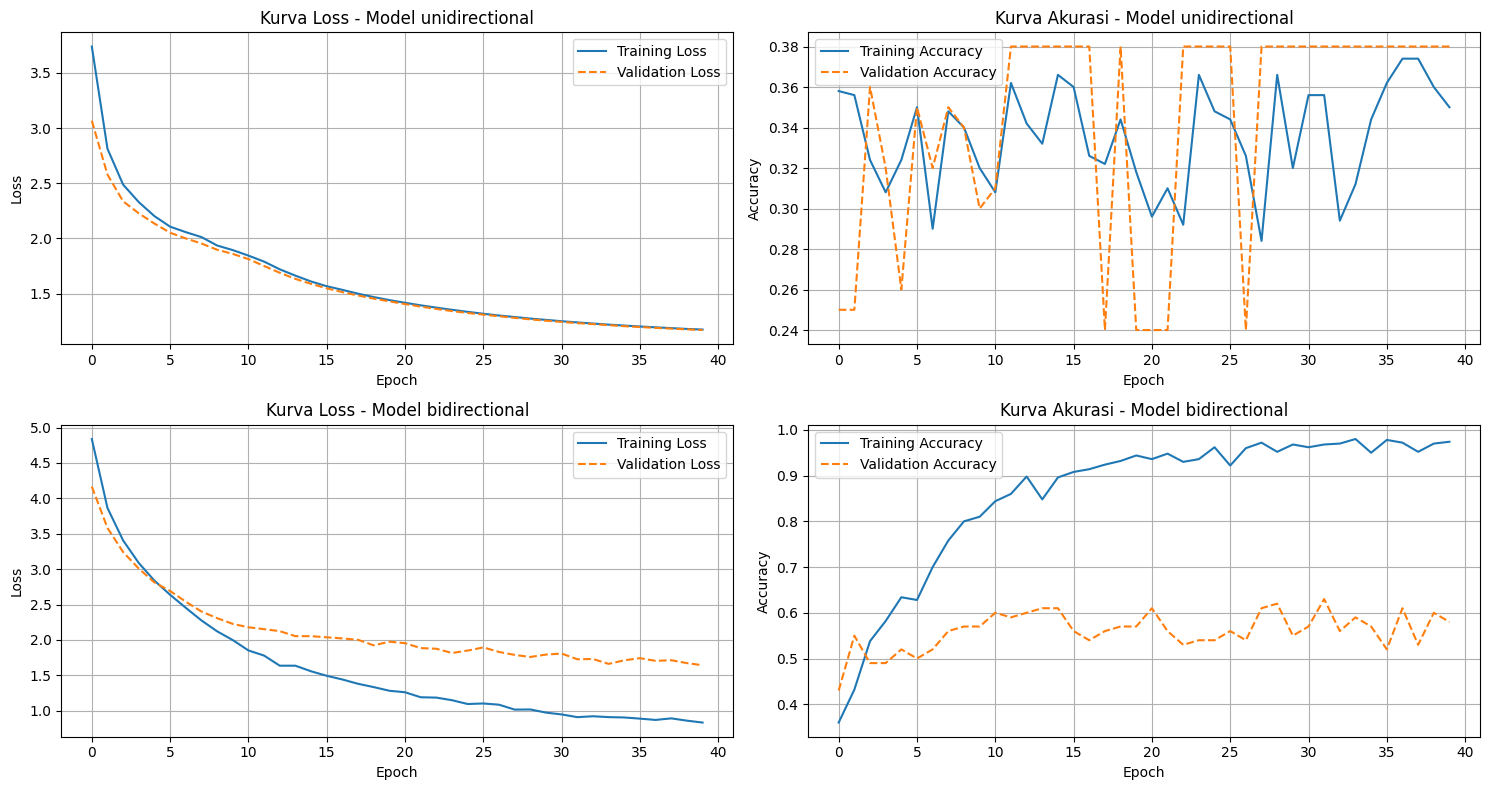

In [25]:
# Tampilkan hasil dalam tabel
print("\nHasil Eksperimen Arah RNN:")
display(bidirectional_results_df)

# Visualisasikan pengaruh arah RNN dengan chart batang
plt.figure(figsize=(10, 6))
directions = bidirectional_results_df['direction'].tolist()
x = np.arange(len(directions))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, bidirectional_results_df['accuracy'], width, label='Accuracy')
rects2 = ax.bar(x + width/2, bidirectional_results_df['f1_score'], width, label='F1 Score')

ax.set_title('Perbandingan RNN Unidirectional vs Bidirectional')
ax.set_ylabel('Skor')
ax.set_xticks(x)
ax.set_xticklabels(directions)
ax.legend()

# Tambahkan nilai di atas bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                   xy=(rect.get_x() + rect.get_width() / 2, height),
                   xytext=(0, 3),
                   textcoords="offset points",
                   ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

# Plot kurva learning untuk perbandingan bidirectional vs unidirectional
plt.figure(figsize=(15, 4 * len(BIDIRECTIONAL_VARIATIONS)))

for i, (direction, history) in enumerate(bidirectional_histories.items()):
    # Plot Loss
    plt.subplot(len(BIDIRECTIONAL_VARIATIONS), 2, 2*i + 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], '--', label='Validation Loss')
    plt.title(f'Kurva Loss - Model {direction}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(len(BIDIRECTIONAL_VARIATIONS), 2, 2*i + 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], '--', label='Validation Accuracy')
    plt.title(f'Kurva Akurasi - Model {direction}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [26]:
# 3.4. Analisis dan Model Optimal


ANALISIS KOMPREHENSIF SEMUA VARIASI
Rangkuman komprehensif disimpan di experiment_results/variation_summary.csv

Rangkuman Dampak Variasi:


,Variasi,Konfigurasi Terbaik,Akurasi,F1 Score,Dampak Relatif
0,"Layer: Terbaik dari [1, 2, 3]",1 layer,0.5950,0.5599,0.1704
1,"Unit: Terbaik dari [24, 48, 96]",24 unit,0.6750,0.6646,0.1019
2,"Arah: Terbaik dari ['Unidirectional', 'Bidirec...",Bidirectional,0.6000,0.5791,0.3964



Variasi dengan dampak terbesar: Arah RNN
Rentang dampak: 0.3964 perbedaan F1 score


<Figure size 1000x600 with 0 Axes>

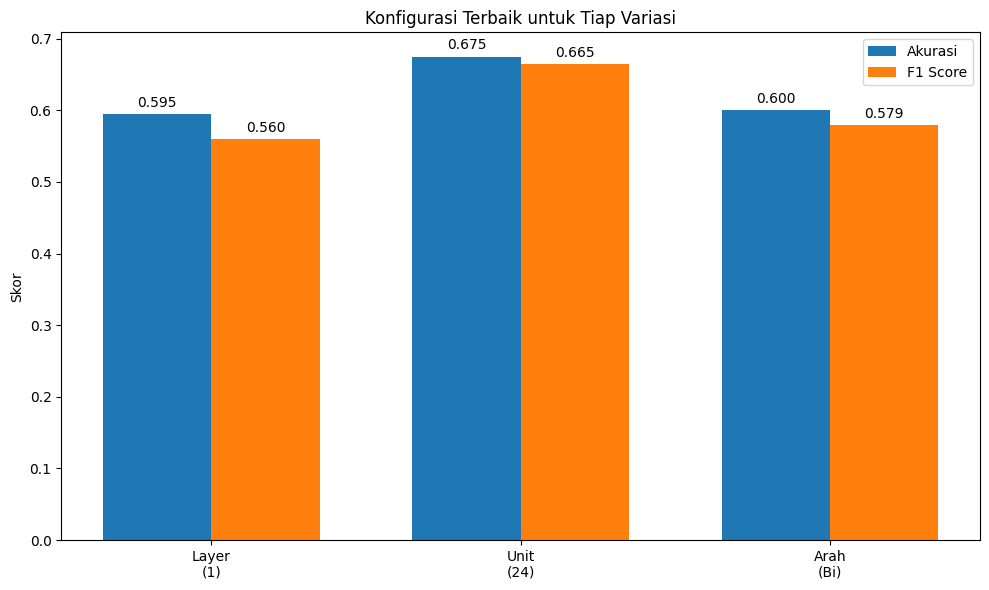


Konfigurasi optimal berdasarkan F1 score:
- Jumlah layer RNN: 1
- Jumlah unit RNN: 24
- Bidirectional: True


In [27]:
def analyze_all_results(layer_results, unit_results, bidirectional_results):
    """Analisis komprehensif dari semua hasil eksperimen"""
    
    print("\n" + "="*50)
    print("ANALISIS KOMPREHENSIF SEMUA VARIASI")
    print("="*50)
    
    # Buat tabel rangkuman
    summary = pd.DataFrame({
        'Variasi': [
            f"Layer: Terbaik dari {RNN_LAYERS_VARIATIONS}",
            f"Unit: Terbaik dari {RNN_UNITS_VARIATIONS}",
            f"Arah: Terbaik dari {['Unidirectional', 'Bidirectional']}"
        ],
        'Konfigurasi Terbaik': [
            f"{layer_results.loc[layer_results['f1_score'].idxmax(), 'num_layers']} layer",
            f"{unit_results.loc[unit_results['f1_score'].idxmax(), 'num_units']} unit",
            f"{'Bidirectional' if bidirectional_results.loc[bidirectional_results['f1_score'].idxmax(), 'is_bidirectional'] else 'Unidirectional'}"
        ],
        'Akurasi': [
            f"{layer_results['accuracy'].max():.4f}",
            f"{unit_results['accuracy'].max():.4f}",
            f"{bidirectional_results['accuracy'].max():.4f}"
        ],
        'F1 Score': [
            f"{layer_results['f1_score'].max():.4f}",
            f"{unit_results['f1_score'].max():.4f}",
            f"{bidirectional_results['f1_score'].max():.4f}"
        ],
        'Dampak Relatif': [
            f"{(layer_results['f1_score'].max() - layer_results['f1_score'].min()):.4f}",
            f"{(unit_results['f1_score'].max() - unit_results['f1_score'].min()):.4f}",
            f"{(bidirectional_results['f1_score'].max() - bidirectional_results['f1_score'].min()):.4f}"
        ]
    })
    
    # Simpan rangkuman ke CSV
    summary_path = f"{RESULTS_DIR}/variation_summary.csv"
    summary.to_csv(summary_path, index=False)
    print(f"Rangkuman komprehensif disimpan di {summary_path}")
    
    # Cetak analisis
    print("\nRangkuman Dampak Variasi:")
    display(summary)
    
    # Tentukan variasi mana yang memberikan dampak terbesar
    impacts = [
        layer_results['f1_score'].max() - layer_results['f1_score'].min(),
        unit_results['f1_score'].max() - unit_results['f1_score'].min(),
        bidirectional_results['f1_score'].max() - bidirectional_results['f1_score'].min()
    ]
    
    variation_names = ['Jumlah Layer', 'Jumlah Unit', 'Arah RNN']
    most_impactful = variation_names[np.argmax(impacts)]
    
    print(f"\nVariasi dengan dampak terbesar: {most_impactful}")
    print(f"Rentang dampak: {max(impacts):.4f} perbedaan F1 score")
    
    # Visualisasikan konfigurasi terbaik untuk setiap variasi
    plt.figure(figsize=(10, 6))
    
    variations = ['Layer', 'Unit', 'Arah']
    best_configs = [
        f"{layer_results.loc[layer_results['f1_score'].idxmax(), 'num_layers']}",
        f"{unit_results.loc[unit_results['f1_score'].idxmax(), 'num_units']}",
        f"{'Bi' if bidirectional_results.loc[bidirectional_results['f1_score'].idxmax(), 'is_bidirectional'] else 'Uni'}"
    ]
    
    best_accuracies = [
        layer_results['accuracy'].max(),
        unit_results['accuracy'].max(),
        bidirectional_results['accuracy'].max()
    ]
    
    best_f1s = [
        layer_results['f1_score'].max(),
        unit_results['f1_score'].max(),
        bidirectional_results['f1_score'].max()
    ]
    
    # Buat label untuk sumbu x yang menunjukkan konfigurasi terbaik
    x_labels = [f"{v}\n({c})" for v, c in zip(variations, best_configs)]
    
    # Plot
    x = np.arange(len(variations))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, best_accuracies, width, label='Akurasi')
    rects2 = ax.bar(x + width/2, best_f1s, width, label='F1 Score')
    
    ax.set_title('Konfigurasi Terbaik untuk Tiap Variasi')
    ax.set_ylabel('Skor')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.legend()
    
    # Tambahkan nilai di atas batang
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                       xy=(rect.get_x() + rect.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    
    fig.tight_layout()
    plt.show()
    
    # Kembalikan konfigurasi optimal berdasarkan F1 score
    optimal_config = {
        'num_rnn_layers': int(layer_results.loc[layer_results['f1_score'].idxmax(), 'num_layers']),
        'rnn_units': int(unit_results.loc[unit_results['f1_score'].idxmax(), 'num_units']),
        'bidirectional': bool(bidirectional_results.loc[bidirectional_results['f1_score'].idxmax(), 'is_bidirectional'])
    }
    
    print("\nKonfigurasi optimal berdasarkan F1 score:")
    print(f"- Jumlah layer RNN: {optimal_config['num_rnn_layers']}")
    print(f"- Jumlah unit RNN: {optimal_config['rnn_units']}")
    print(f"- Bidirectional: {optimal_config['bidirectional']}")
    
    return optimal_config

# Analisis hasil dari semua eksperimen untuk menemukan konfigurasi optimal
optimal_config = analyze_all_results(layer_results_df, unit_results_df, bidirectional_results_df)


PELATIHAN MODEL DENGAN KONFIGURASI OPTIMAL

Pelatihan model optimal: optimal_rnn_l1_u24_bi
Konfigurasi: {'num_rnn_layers': 1, 'rnn_units': 24, 'bidirectional': True}

--- Training Model: optimal_rnn_l1_u24_bi ---
Config: Layers=1, Units=24, Bidirectional=True, Dropout=0.3, L2=0.01
Ukuran dataset: Train=500, Valid=100, Test=400
Distribusi kelas di data train: [192 119 189]
Menggunakan bobot kelas: {0: 0.8680555555555556, 1: 1.4005602240896358, 2: 0.8818342151675485}
Ukuran vocabulary: 2836


Model: "Simple_RNN_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dropout               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_rnn_1             │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_rnn_1 (Dropout)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_layer (Dense)      │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Mulai pelatihan model...
Epoch 1/40
19/21 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3187 - loss: 4.3095
Epoch 1: val_loss improved from inf to 3.25572, saving model to checkpoints/optimal_rnn_l1_u24_bi.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.3189 - loss: 4.2584 - val_accuracy: 0.3000 - val_loss: 3.2557 - learning_rate: 0.0010
Epoch 2/40
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4244 - loss: 3.0476
Epoch 2: val_loss improved from 3.25572 to 2.71538, saving model to checkpoints/optimal_rnn_l1_u24_bi.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4227 - loss: 3.0373 - val_accuracy: 0.3400 - val_loss: 2.7154 - learning_rate: 0.0010
Epoch 3/40
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4482 - loss: 2.6085
Epoch 3: val_loss improved from 2.71538 to 2.48158, saving model to checkpoints/optimal_rnn_l1_u24_bi.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4486 - loss: 2.6038 - val_accuracy: 0.3600 - val_lo

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


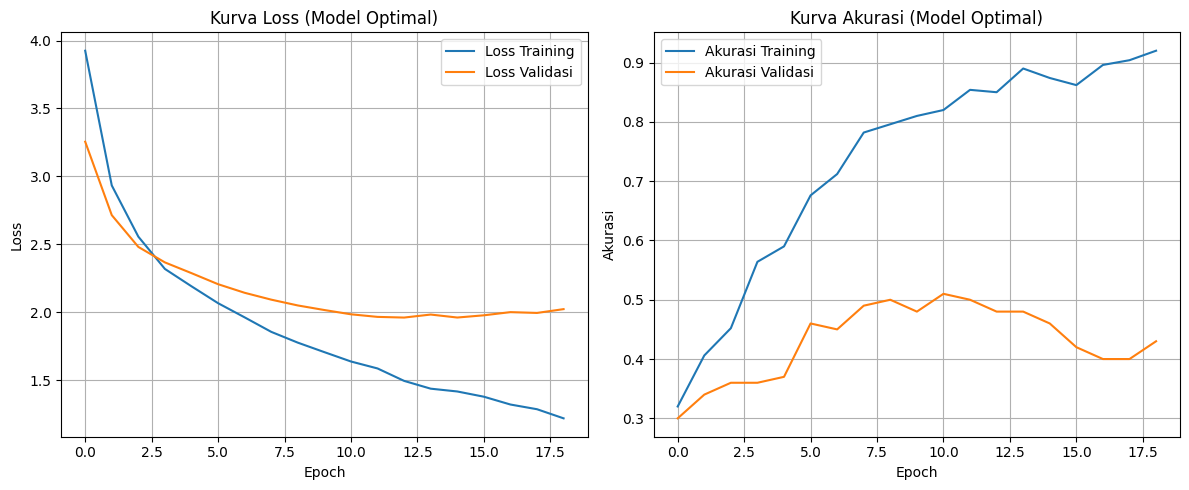

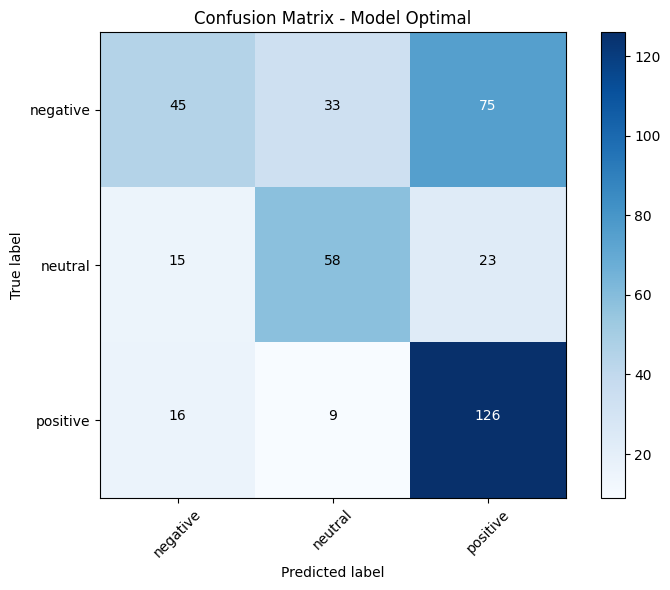

In [28]:
def run_optimal_model(optimal_config):
    """Latih model dengan konfigurasi optimal dari hasil eksperimen"""
    print("\n" + "="*50)
    print("PELATIHAN MODEL DENGAN KONFIGURASI OPTIMAL")
    print("="*50)
    
    # Buat nama model yang menggambarkan konfigurasinya
    model_name = f"optimal_rnn_l{optimal_config['num_rnn_layers']}_u{optimal_config['rnn_units']}_{'bi' if optimal_config['bidirectional'] else 'uni'}"
    
    print(f"\nPelatihan model optimal: {model_name}")
    print(f"Konfigurasi: {optimal_config}")
    
    # Latih dengan konfigurasi optimal
    model, history, preds, labels, vectorizer, metrics = train_and_evaluate_model(
        num_rnn_layers=optimal_config['num_rnn_layers'],
        rnn_units=optimal_config['rnn_units'],
        bidirectional=optimal_config['bidirectional'],
        model_name=model_name
    )
    
    print("\nPerforma Model Optimal:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
    
    # Plot kurva training
    plt.figure(figsize=(12, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Loss Training")
    plt.plot(history.history["val_loss"], label="Loss Validasi")
    plt.title(f"Kurva Loss (Model Optimal)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="Akurasi Training")
    plt.plot(history.history["val_accuracy"], label="Akurasi Validasi")
    plt.title(f"Kurva Akurasi (Model Optimal)")
    plt.xlabel("Epoch")
    plt.ylabel("Akurasi")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Tambahkan confusion matrix untuk model optimal
    y_pred = np.argmax(preds, axis=1)
    cm = confusion_matrix(labels, y_pred)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix - Model Optimal')
    plt.colorbar()
    class_names = list(label_mapping.keys())
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    
    # Tambahkan nilai di setiap sel
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.show()
    
    return model, vectorizer, metrics

# Latih model dengan konfigurasi optimal
optimal_model, optimal_vectorizer, optimal_metrics = run_optimal_model(optimal_config)

# 4. Implementasi Forward Propagation dari Awal (From Scratch)
Di sini kita mengimplementasikan forward propagation dari awal menggunakan NumPy dan membandingkannya dengan implementasi Keras.

Menggunakan model optimal dari: models/optimal_rnn_l1_u24_bi_full_model.keras

SIMPLE RNN FROM SCRATCH IMPLEMENTATION
Loaded test data: 400 samples
Loading Keras model from: models/optimal_rnn_l1_u24_bi_full_model.keras


Model: "Simple_RNN_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 80, 96)         │       272,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dropout               │ (None, 80, 96)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_rnn_1             │ (None, 48)             │         5,808 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_rnn_1 (Dropout)         │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_layer (Dense)      │ (None, 3)              │           147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 834,635 (3.18 MB)

 Trainable params: 278,211 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 556,424 (2.12 MB)

Layers in model: ['embedding_layer', 'embedding_dropout', 'bidirectional_rnn_1', 'dropout_rnn_1', 'output_dense_layer']
Embedding weights shape: (2836, 96)
Found 1 bidirectional layers
Layer 1 - Forward RNN kernel shape: (96, 24)
Layer 1 - Forward RNN recurrent kernel shape: (24, 24)
Output kernel shape: (48, 3)
Output bias shape: (3,)
Loading vectorizer from: models/optimal_rnn_l1_u24_bi_vectorizer.keras
Model loaded and weights extracted successfully

Membandingkan implementasi pada data test...
Embedded shape: (400, 80, 96), min: -0.09840147197246552, max: 0.0883651077747345, mean: 0.003335726447403431
RNN output shape: (400, 48), min: -0.7243711829518101, max: 0.6660310847170104, mean: -0.014068706200220176
Logits: [[-0.21991216 -0.84373608  0.67457272]
 [ 0.21829121  0.86975031 -0.87862261]]
Unique predicted classes: [0 1 2]
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step

Perbandingan waktu prediksi:
From scratch: 0.1310 detik
Keras: 0.7946 detik
Rasio waktu (scratch/keras): 0.16x

Akura

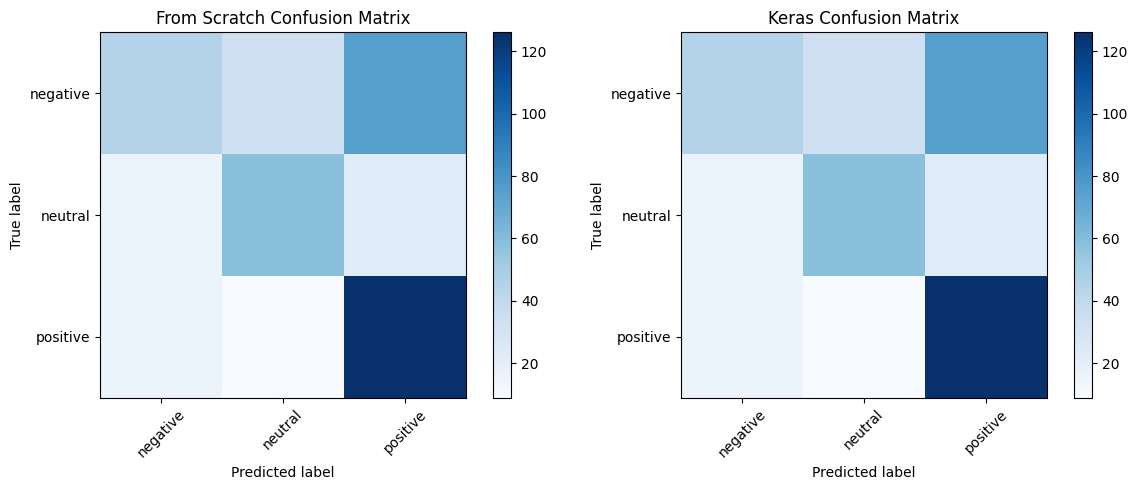

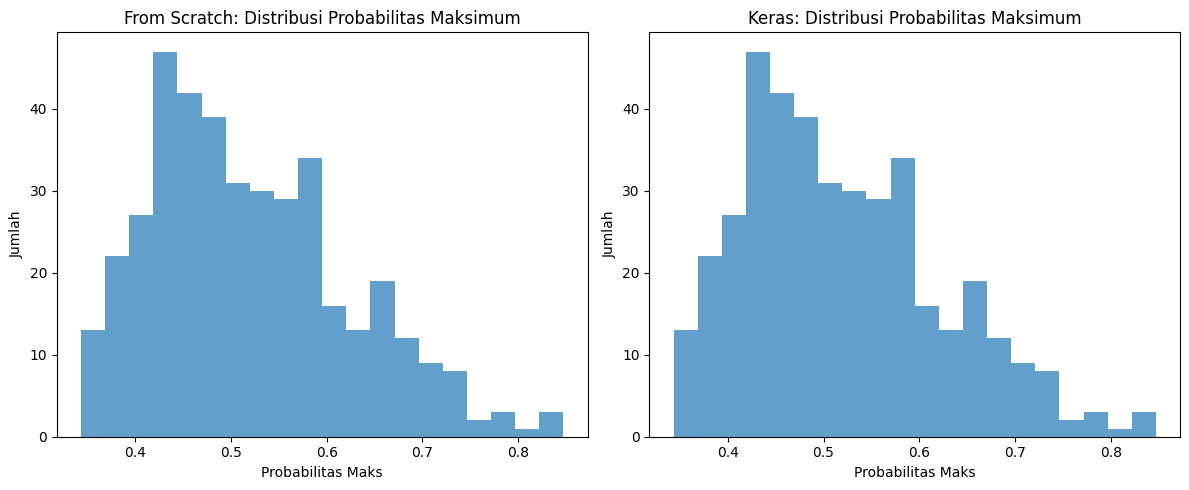

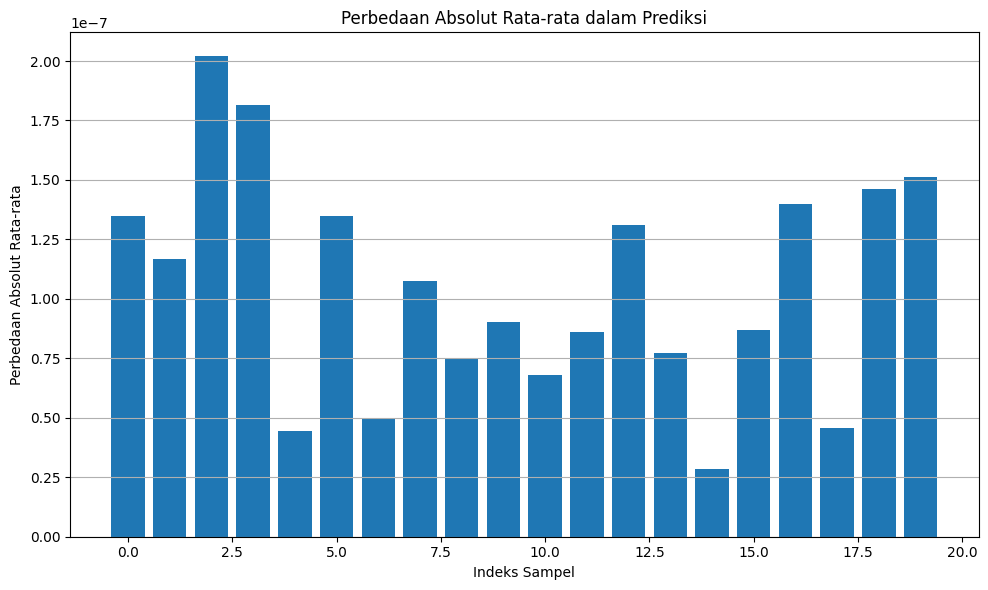

In [29]:
from from_scratch import SimpleRNNFromScratch, run_from_scratch_comparison

# Tentukan path model yang akan digunakan untuk implementasi from scratch
model_path = f"models/optimal_rnn_l{optimal_config['num_rnn_layers']}_u{optimal_config['rnn_units']}_{'bi' if optimal_config['bidirectional'] else 'uni'}_full_model.keras"
vectorizer_path = f"models/optimal_rnn_l{optimal_config['num_rnn_layers']}_u{optimal_config['rnn_units']}_{'bi' if optimal_config['bidirectional'] else 'uni'}_vectorizer.keras"

print(f"Menggunakan model optimal dari: {model_path}")

# Jalankan perbandingan implementasi from scratch dengan Keras
scratch_rnn = run_from_scratch_comparison(model_path, vectorizer_path)

# 4.1 Prediksi Contoh dengan Implementasi From Scratch

In [30]:
# Contoh beberapa teks untuk pengujian
sample_texts = [
    "Film ini sangat bagus, saya sangat menikmatinya!",
    "Pelayanan di hotel ini mengecewakan dan kamarnya kotor.",
    "Harga produk ini cukup standar, tidak mahal tidak murah.",
    "Saya tidak suka dengan rasa makanannya, terlalu asin."
]

# Lakukan prediksi menggunakan implementasi from scratch
scratch_predictions = scratch_rnn.predict(sample_texts)

# Tampilkan hasil prediksi
print("Prediksi Sentimen dengan Implementasi From Scratch:")
sentiment_classes = list(label_mapping.keys())
for i, text in enumerate(sample_texts):
    pred_class = np.argmax(scratch_predictions[i])
    pred_prob = scratch_predictions[i][pred_class]
    print(f"\nTeks: {text}")
    print(f"Sentimen yang diprediksi: {sentiment_classes[pred_class]} dengan probabilitas {pred_prob:.4f}")
    probas = [f"{sentiment_classes[j]}: {scratch_predictions[i][j]:.4f}" for j in range(len(sentiment_classes))]
    print(f"Probabilitas per kelas: {', '.join(probas)}")


Embedded shape: (4, 80, 96), min: -0.09507404267787933, max: 0.0883651077747345, mean: 0.004340642131865025
RNN output shape: (4, 48), min: -0.27262922737710366, max: 0.24044121555868542, mean: -0.005153574001046268
Logits: [[-0.13208471  0.1573231  -0.02017374]
 [ 0.00664993 -0.17521295  0.09268909]]
Unique predicted classes: [1 2]
Prediksi Sentimen dengan Implementasi From Scratch:

Teks: Film ini sangat bagus, saya sangat menikmatinya!
Sentimen yang diprediksi: neutral dengan probabilitas 0.3867
Probabilitas per kelas: negative: 0.2895, neutral: 0.3867, positive: 0.3238

Teks: Pelayanan di hotel ini mengecewakan dan kamarnya kotor.
Sentimen yang diprediksi: positive dengan probabilitas 0.3728
Probabilitas per kelas: negative: 0.3420, neutral: 0.2852, positive: 0.3728

Teks: Harga produk ini cukup standar, tidak mahal tidak murah.
Sentimen yang diprediksi: positive dengan probabilitas 0.3666
Probabilitas per kelas: negative: 0.3313, neutral: 0.3020, positive: 0.3666

Teks: Saya tidak

# 5. Kesimpulan dan Analisis Akhir

Perbandingan Semua Model:


,model,accuracy,f1_score
0,Baseline,0.4900,0.444306
1,Layer Terbaik (1 layer),0.5950,0.559938
2,Unit Terbaik (24 unit),0.6750,0.664583
3,Arah Terbaik (bidirectional),0.6000,0.579119
4,Model Optimal,0.5725,0.552283


<Figure size 1000x600 with 0 Axes>

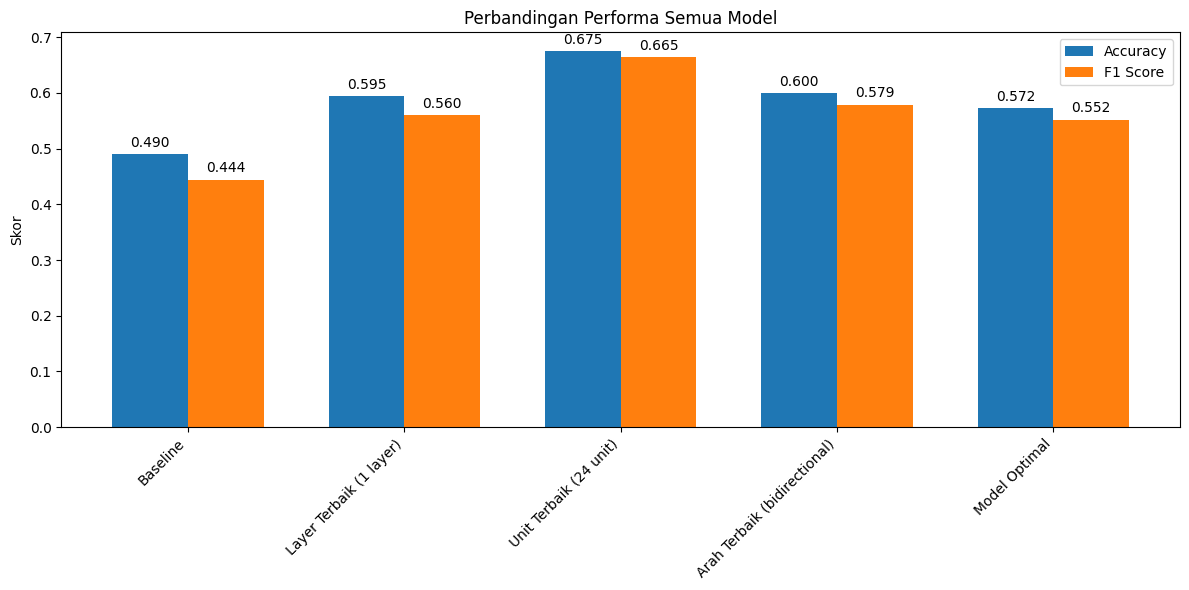

In [31]:
# Membuat tabel perbandingan semua model yang diuji
all_models = pd.DataFrame([
    {"model": "Baseline", "accuracy": metrics_baseline['test_accuracy'], "f1_score": metrics_baseline['test_f1']},
    {"model": f"Layer Terbaik ({layer_results_df.loc[layer_results_df['f1_score'].idxmax(), 'num_layers']} layer)", 
     "accuracy": layer_results_df['accuracy'].max(), "f1_score": layer_results_df['f1_score'].max()},
    {"model": f"Unit Terbaik ({unit_results_df.loc[unit_results_df['f1_score'].idxmax(), 'num_units']} unit)", 
     "accuracy": unit_results_df['accuracy'].max(), "f1_score": unit_results_df['f1_score'].max()},
    {"model": f"Arah Terbaik ({'bi' if bidirectional_results_df.loc[bidirectional_results_df['f1_score'].idxmax(), 'is_bidirectional'] else 'uni'}directional)", 
     "accuracy": bidirectional_results_df['accuracy'].max(), "f1_score": bidirectional_results_df['f1_score'].max()},
    {"model": "Model Optimal", "accuracy": optimal_metrics['test_accuracy'], "f1_score": optimal_metrics['test_f1']}
])

# Tampilkan tabel perbandingan
print("Perbandingan Semua Model:")
display(all_models)

# Plot perbandingan performa model
plt.figure(figsize=(10, 6))
x = np.arange(len(all_models))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, all_models['accuracy'], width, label='Accuracy')
rects2 = ax.bar(x + width/2, all_models['f1_score'], width, label='F1 Score')

ax.set_title('Perbandingan Performa Semua Model')
ax.set_ylabel('Skor')
ax.set_xticks(x)
ax.set_xticklabels(all_models['model'], rotation=45, ha='right')
ax.legend()

# Tambahkan nilai di atas bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                   xy=(rect.get_x() + rect.get_width() / 2, height),
                   xytext=(0, 3),
                   textcoords="offset points",
                   ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()